# Análisis de imágenes de Sargazo

### Librerías

In [1]:
# Librería de OpenCV
import cv2
# Librería Numpy para Arrays y operaciones matriciales
import numpy as np
# Libreria para las gráficas
import matplotlib.pyplot as plt
import matplotlib.cm as cm #Mapa de colores
from PIL import Image #Procesamiento de imagenes

from scipy.ndimage import convolve #Convolucion
from scipy.fft import fft2, ifft2, fftshift #Transformadas de Fourier

from skimage.color import label2rgb #Colorear las etiquetas en una imagen segmentada

#Filtros
from skimage.filters import sobel,laplace,unsharp_mask

### Funciones para cargar y mostrar imagenes

In [21]:
#Funcion que recibebe la direccion de la carpeta con las imagenes muestra, con un nombre base seguido de un arreglo de numeros y el tipo de archivo (debe ser la misma)
def ReadImg(folderPath,baseName,samples,fileExtension):
    images = list() #Se crea una lista vacia para contener las imagenes
    for i in samples: #Para cada imagen enumerada desde el 1
        filePath=folderPath + baseName + str(i) + fileExtension #Se crea un string para almacenar la direccion de cada imagen
        try:
            images.append(Image.open(filePath,"r").convert("HSV")) #Se intenta agregar la imagen en formato HSV
        except:
            print("No se logro agregar la imagen",filePath) #Si hay algun error, se da un aviso
            
    return images #Se regresa una lista de imagenes

In [22]:
#Mostrar varias imagenes en una sola figura
def showNImg(imgList):
    fig, plots = plt.subplots(1,len(imgList)) #Se crean las graficas en una lista de subplots

    for i in range(0,len(imgList)):
        plots[i].imshow(imgList[i]) #Se muestra cada imagen de entrenamiento

In [35]:
#Funcion para obtener las imagenes de entrenamiento con la mascara de recorte a partir del canal alpha.
def ReadImgHSVAlpha(folderPath,baseName,samples,fileExtension):
    images = list() #Se crea una lista vacia para contener las imagenes
    alphas = list() #Se crea una lista vacia para contener los canales alpha
    for i in range(1,samples+1): #Para cada imagen enumerada desde el 1
        filePath=folderPath + baseName + str(i) + fileExtension #Se crea un string para almacenar la direccion de cada imagen
        try:
            img = Image.open(filePath) #Se guarda la imagen en una variable
            images.append(np.array(img.convert("HSV")))
            alpha = np.asarray(img.split()[-1]) #Se extrae el canal alpha
            alphas.append(alpha) #Se agrega la mascara a la lista
        except:
            print("No se logro agregar la imagen",filePath) #Si hay algun error, se da un aviso
            
    return images, alphas #Se regresa una lista de imagenes

## Pruebas con la iluminación

Se tomaron tres imágenes de prueba con distinta iluminación y tamaño del cuerpo de sargazo, para poder determinar de manera empírica qué filtros podrían facilitar la detección.

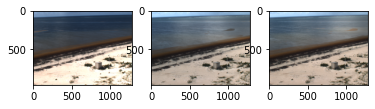

In [36]:
#Se toman imagenes de prueba con distinta iluminacion
imges = ReadImg('Test/','Test',[1,2,3],'.png')
showNImg(imges)

(960, 1280, 3)
[[0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 -- -- -- -- -- --]
 [-- -- -- -- -- -- -- -- -- --]
 [-- -- -- -- -- -- -- -- -- --]]


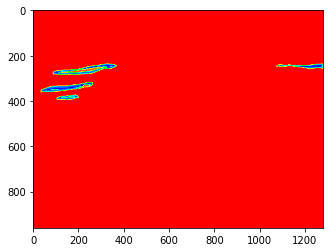

In [55]:
train, mask = ReadImgHSVAlpha("Training/","Train",23,".png")
plt.imshow(train[4][:,:,0], cmap = cm.hsv)
print(np.array(train[0]).shape)
print(np.ma.array(train[0][:,:,0], mask = mask[0])[250:260,:10])

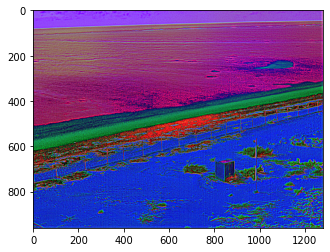

In [5]:
testImg = np.array(imges[2])
testImg = unsharp_mask(testImg,radius=3,amount=5,multichannel=True)

plt.imshow(testImg)
plt.hsv()

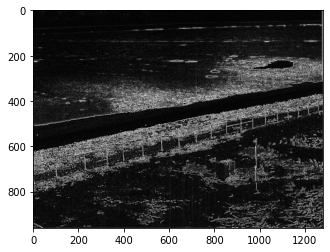

In [6]:
test2 = sobel(testImg[:,:,0])
plt.imshow(test2,cmap=cm.gray)

0.0


<ipython-input-7-7c9e9baaac25>:4: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(fftshift(np.abs(Fimg1[:,:,2]))),cmap=cm.jet)


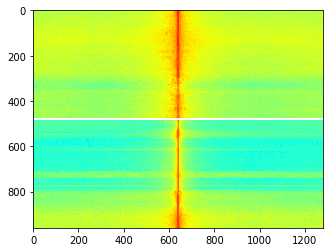

In [7]:
imgTest = np.array(imges[1])
Fimg1=fft2(imgTest)
print(np.min(abs(Fimg1)))
plt.imshow(np.log10(fftshift(np.abs(Fimg1[:,:,2]))),cmap=cm.jet)

In [8]:
dd2_5x5 = [1,0,-2,0,1]
g_5x5 = [1,4,6,4,1]
kernel = np.outer(g_5x5,dd2_5x5)
kernel = kernel + kernel.T
kernel[2,2]+=1
print(kernel)

[[  2   4   4   4   2]
 [  4   0  -8   0   4]
 [  4  -8 -23  -8   4]
 [  4   0  -8   0   4]
 [  2   4   4   4   2]]


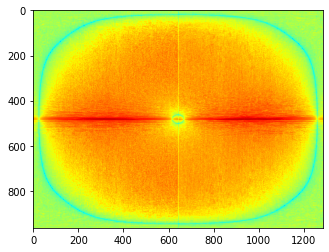

In [9]:
dim = np.add(Fimg1[:,:,0].shape,kernel.shape)-1
Fimg2=fft2(Fimg1[:,:,2],dim)
Ffiltro = fft2(kernel,dim)
res =np.multiply(Fimg2,Ffiltro)
plt.imshow(np.log10(fftshift(abs(res))),cmap=cm.jet)

[[ 361844.36322264  714750.92028134  715387.3555013   716150.85366955
   352914.26223908   89929.18998699   46598.65480541   51966.94176408
    46710.83339202   40497.61188571]
 [1083101.14045919  699248.17041645  741561.9744331   731768.4074664
  1016632.65960705  165325.84042475   17577.16605303   79332.18460032
    66244.15265862   13429.91615453]
 [1801416.05148727  811898.5747766  4834503.10609517  868855.23786171
  1717441.52505533  151711.52343586  185234.40680905   48175.07468267
    32868.09437299  113752.75341347]
 [2518162.64940849  850810.40833491 6242067.58745726  949921.26300131
  2408018.28124468  230427.00864576  234392.43914095   59982.66335506
    43929.04439624  135764.89914373]
 [2872016.15984033  352007.69564355 5519957.64446684  635279.86903893
  2734599.64766373  300377.75831308  188291.26592792  105895.53658182
    88959.64764611   81824.92397189]
 [2866676.73449589  345953.22775857 5513150.63110092  619529.99175449
  2730899.10571806  278167.9727945   184772.76

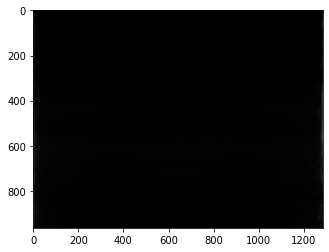

In [10]:
imgRes = ifft2(res)
plt.imshow(abs(imgRes),cmap=cm.gray)
print(abs(imgRes[:10,:10]))

## Pruebas con superpixeles

In [11]:
def imagetoSP(img):
    # Crear el objeto de SLIC con las propiedades especificadas
    slic = cv2.ximgproc.createSuperpixelSLIC(img, algorithm = cv2.ximgproc.SLIC, region_size = 20, ruler = 20.0)
    # Iterar el algoritmo
    slic.iterate()
    # Obtener la máscara de los ejes de los Super pixeles
    mask_slic = slic.getLabelContourMask()
    # Obtener un numpy array con los indices de los superpixeles
    label_slic = slic.getLabels()
    # Obtener el número de Super pixeles generados
    number_slic = slic.getNumberOfSuperpixels()
    # Negar la máscara de los superpixeles para poder haceer operaciones con esta
    mask_inv_slic = cv2.bitwise_not(mask_slic)  
    # Hacer la operación booleana de la máscara de Super Pixeles y la imagen original
    img_slic = cv2.bitwise_and(img,img,mask =  mask_inv_slic)
    # RESULTADOS
    return img_slic, label_slic, number_slic

In [12]:
slicIm, lblSlic, n_Slic = imagetoSP(np.array(imges[0]))

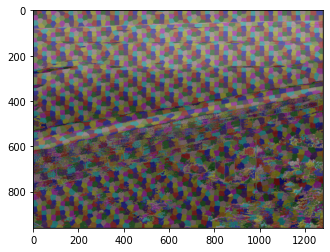

In [13]:
color1 = label2rgb(lblSlic, image=np.array(imges[0]), bg_label=0)
plt.imshow(color1)